### Step 1: Run preliminary imports, set directories, etc.

In [1]:
import numpy as np
import pandas as pd
import sys, copy, requests, time, json
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# for interactive sliders, etc.
from ipywidgets import interact, interactive, fixed, interact_manual

# for getting discovery date from TNS
from lxml import html
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

#https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

lc_info = pdastrostatsclass()

In [2]:
# Enter your data directory (where the SN light curves are located) here:
global dir
dir = '/Users/sofiarest/OneDrive - Johns Hopkins/Freshman Year/researchpaper/atlaslc_chisquare/brightsne/'

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

### Step 2: Load in light curves
Enter the TNS name for each SN you wish to load in and examine/cut in the cell below.

In [3]:
# Enter each SN's TNS name here:
lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2018pv','2017guh','2018oh']

# Optionally, enter each SN's discovery date (start of SN) here:
lc_info.t['mjdstart'] = [59005.264,58818.04,58975.20256,58152.631331,58014.31,58153.49]

In [4]:
# set up the rest of lc_info (discovery date, loading in lc, etc.)

lc_info.t['classification'] = ['good','bad',None,None,None,None]
lc_info.t['lc'] = [None] * len(lc_info.t)

# get the discovery date for each SN
print('Obtaining discovery date information from TNS if needed...')
def get_tns_data(tnsname):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':'2eca323a16b17d78fbc99cd6f1f801699a81a91c','data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error message : \n'+str(e)
def get_disc_date(tnsname):
	json_data = get_tns_data(tnsname)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+"T"+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	#print(tnsname+" discovery date (MJD): %.4f" % disc_date)
	return disc_date
def get_disc_date_loop(lc_info):
	for index in range(0,len(lc_info.t)):
		if lc_info.t.loc[index,'mjdstart'] is None:
			disc_date = get_disc_date(lc_info.t.loc[index,'tnsname'])
			lc_info.t.loc[index,'mjdstart'] = disc_date
	return lc_info
lc_info = get_disc_date_loop(lc_info)
lc_info.write(columns=['tnsname','mjdstart','classification'])

# load in the lcs from files
print('\nLoading in light curves...')
def load_lc_loop(lc_info):
	for index in range(0,len(lc_info.t)):
		lc_info.t.loc[index,'lc'] = pdastrostatsclass()
		filename = dir+lc_info.t.loc[index,'tnsname']+'/'+lc_info.t.loc[index,'tnsname']+'_i000.o.lc.txt'
		try:
			lc_info.t.loc[index,'lc'].load_spacesep(filename,delim_whitespace=True)
		except Exception as e:
			print('Could not load light curve for SN %s at %s: %s' % (lc_info.t.loc[index,'tnsname'], filename, str(e)))
			sys.exit()
	print('Success')
	return lc_info
lc_info = load_lc_loop(lc_info)

Obtaining discovery date information from TNS if needed...
tnsname     mjdstart classification
2020lse 59005.264000           good
2019vxm 58818.040000            bad
2020jfo 58975.202560           None
 2018pv 58152.631331           None
2017guh 58014.310000           None
 2018oh 58153.490000           None

Loading in light curves...
Success


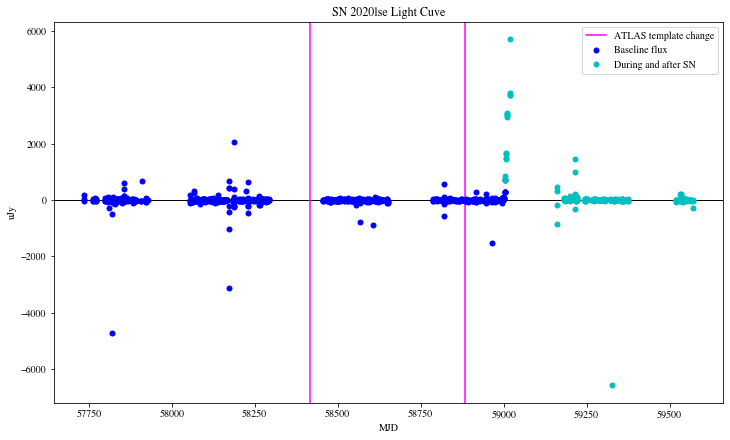

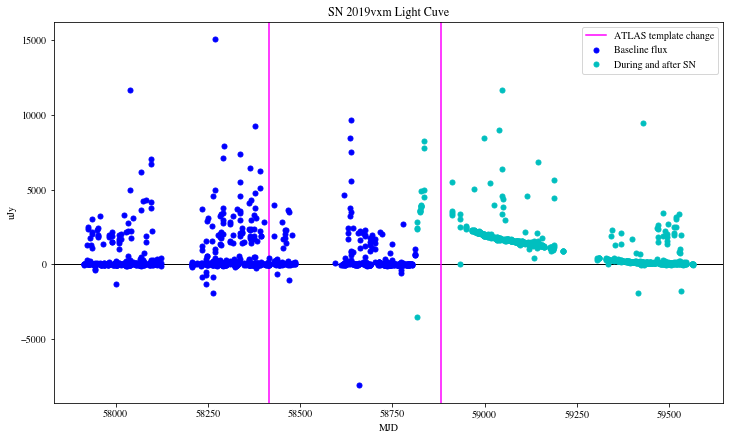

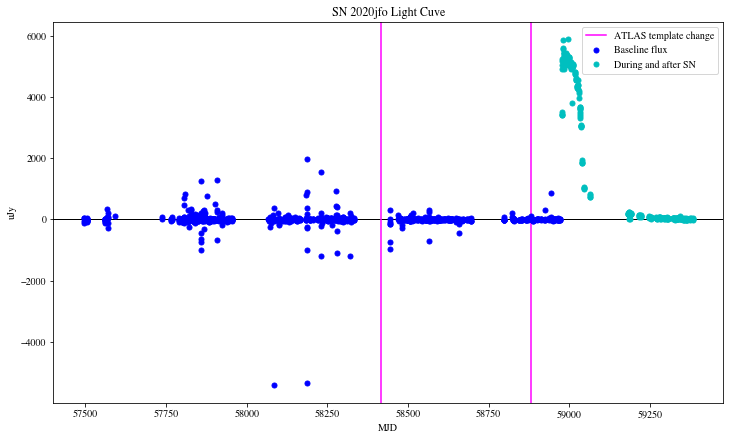

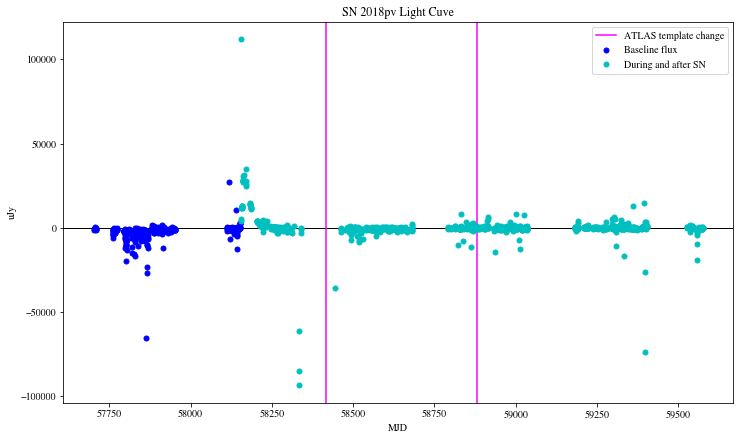

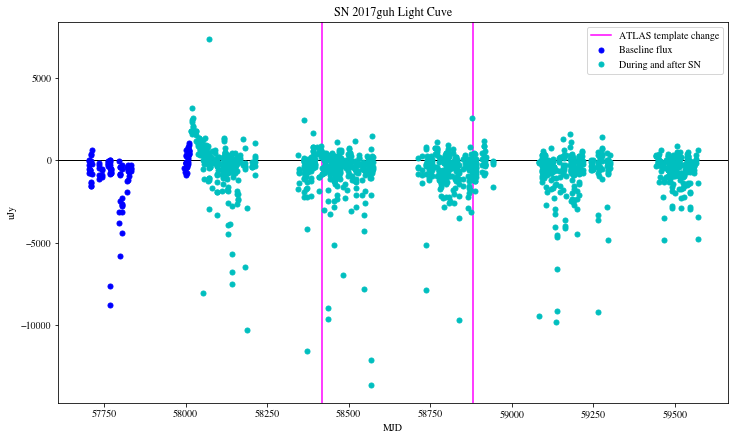

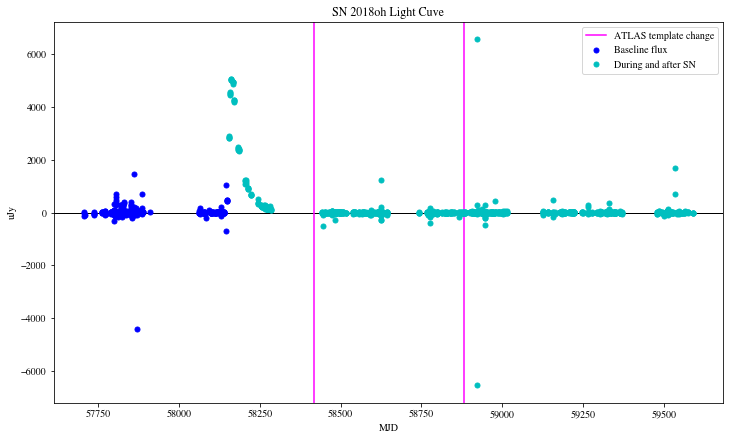

In [8]:
# plot each light curve
def prelim_plot_lc(info):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('uJy')
    ax.set_xlabel('MJD')
    ax.set_title('SN '+info['tnsname']+' Light Cuve')
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')
    return fig, ax
def plot_lc_mjdstart(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    duringsn = np.where(info['lc'].t['MJD'] > info['mjdstart'])[0]

    fig, ax = prelim_plot_lc(info)
    sp, plot_baseline, dplot = dataPlot(info['lc'].t.loc[baseline,'MJD'], info['lc'].t.loc[baseline,'uJy'], sp=ax)
    matlib.setp(plot_baseline,ms=5,color='b',marker='o',label='Baseline flux')
    sp, plot_aftersn, dplot = dataPlot(info['lc'].t.loc[duringsn,'MJD'], info['lc'].t.loc[duringsn,'uJy'], sp=ax)
    matlib.setp(plot_aftersn,ms=5,color='c',marker='o',label='During and after SN')
    plt.legend()
def plot_lc_mjdstart_loop(lc_info):
    for index in range(0,len(lc_info.t)):
        plot_lc_mjdstart(lc_info.t.loc[index])
plot_lc_mjdstart_loop(lc_info)
